In [1]:
import pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt, numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import rc
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [21]:
data_orig = pd.read_csv('parking-citations.csv')
data_orig.columns = data_orig.columns.str.replace(' ','')

data = data_orig[data_orig.IssueDate.notnull()]
data = data[['Ticketnumber', 'IssueDate']]
data.loc[:,'IssueDate'] = pd.to_datetime(data.loc[:,'IssueDate']).dt.to_period(freq='M')
data_grp = data.groupby(by='IssueDate').count()
data_grp.index = data_grp.index.to_timestamp()

In [22]:
total_data = data_grp[data_grp.index < '2013-09'] 
split_pct = .9
split_ind = int(split_pct * len(total_data)) - 1

In [23]:
train_data, test_data = total_data[:split_ind], total_data[split_ind:]
print('Training Data : {} \nTesting Data : {}'.format(len(train_data), len(test_data)) )

Training Data : 36 
Testing Data : 6


In [28]:
ewma = train_data.Ticketnumber.ewm(span=20).mean()
ewma_std = train_data.Ticketnumber.ewm(span=20).std()

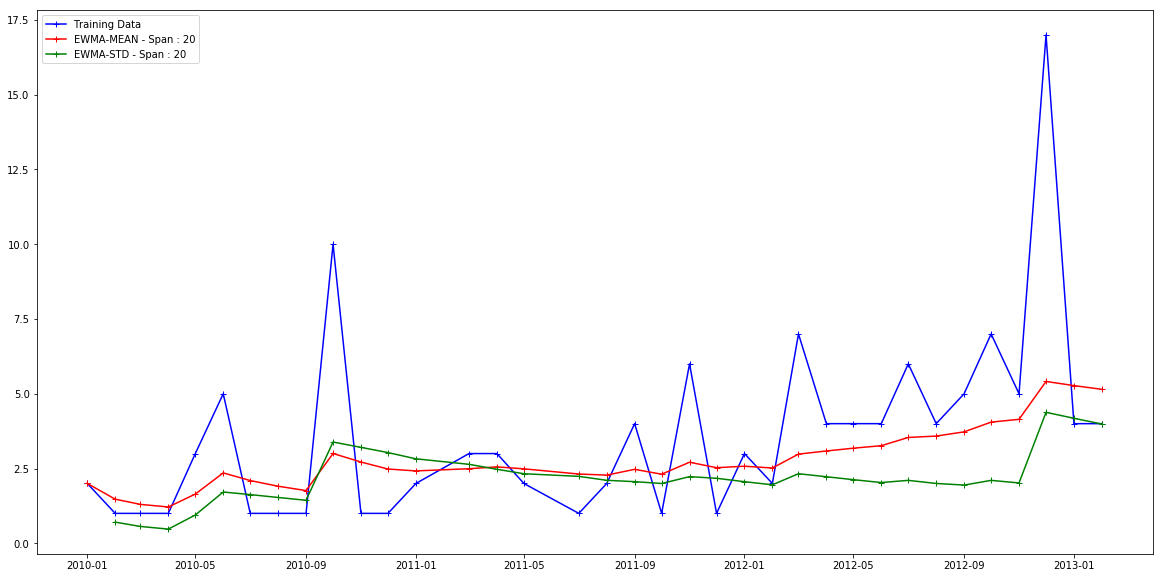

In [38]:
fig1 = plt.figure(figsize=(20,10))
plt.plot(train_data, color = 'b', marker = '+', label = 'Training Data')
plt.plot(ewma, color = 'r', marker = '+', label = 'EWMA-MEAN - Span : 20')
plt.plot(ewma_std, color = 'g', marker = '+', label = 'EWMA-STD - Span : 20')
plt.legend(loc = 'best')

In [67]:
ewma_shift = train_data.Ticketnumber - ewma
ewma_shift = ewma_shift - ewma_shift.shift(1)
data_shift = train_data.Ticketnumber - train_data.Ticketnumber.shift(1)

In [68]:
sm.tsa.adfuller(data_shift[1:])

(-5.907281408748916,
 2.6900028158422705e-07,
 3,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 128.06098960617098)

In [69]:
sm.tsa.adfuller(ewma_shift[1:])

(-4.98336593771661,
 2.393839157918162e-05,
 4,
 30,
 {'1%': -3.6699197407407405,
  '5%': -2.9640707407407407,
  '10%': -2.621171111111111},
 123.86949598920272)

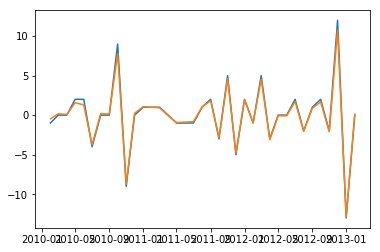

In [70]:
plt.plot(data_shift)
plt.plot(ewma_shift)

In [127]:
model_1 = sm.tsa.ARIMA(data_shift[1:], order=(2,0,0)).fit(disp=-1)

x = data_shift.index[-6:]
x = x.shift(7, freq='M')
x = x.to_period('M').to_timestamp()
preds = pd.Series(model_1.predict(data_shift[1:].shape[0], data_shift[1:].shape[0]+5).values, index = x)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\Anaconda3\lib\site-

In [130]:
model_preds = model_1.fittedvalues.append(preds)

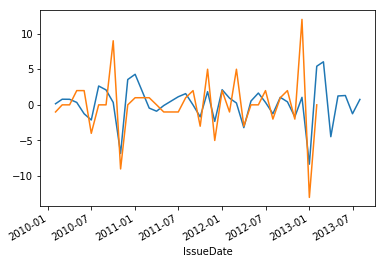

In [129]:
model_1.fittedvalues.append(preds).plot()
data_shift.plot()

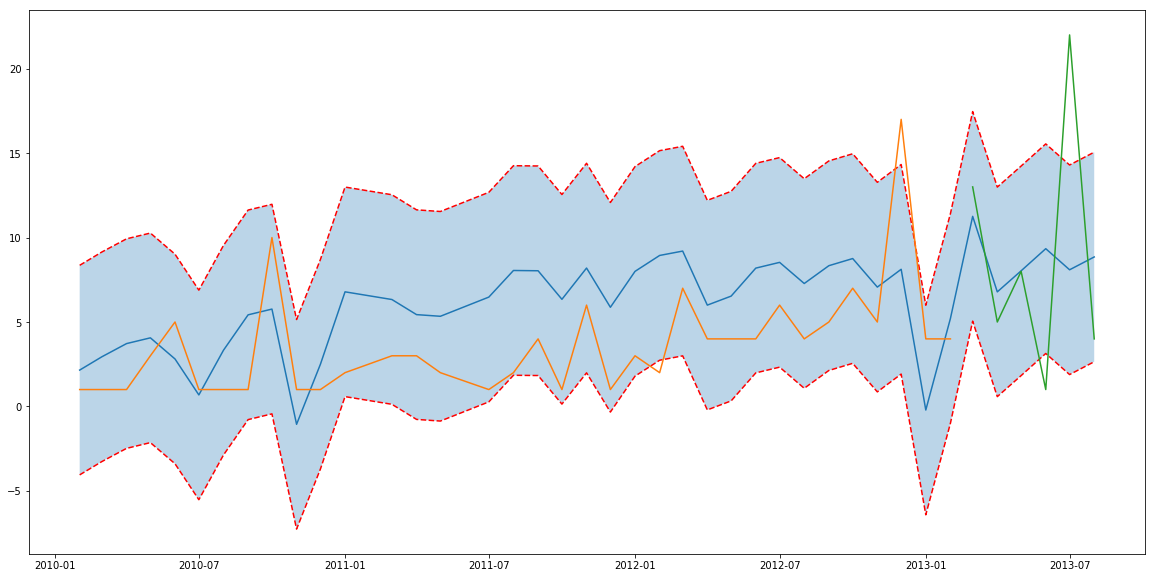

In [176]:
SE = train_data.Ticketnumber.std()
model_upper = model_preds.cumsum().add(train_data.Ticketnumber[0]) + (1.96 * SE)
model_lower = model_preds.cumsum().add(train_data.Ticketnumber[0]) - (1.96 * SE)

fig2 = plt.figure(figsize=(20,10) )

plt.plot(model_preds.cumsum().add(train_data.Ticketnumber[0]))
plt.plot(model_upper[:], color = 'r', linestyle = '--')
plt.plot(model_lower[:], color = 'r', linestyle = '--')
plt.plot(train_data[1:])
plt.plot(test_data)
plt.fill_between(model_lower.index[:], model_upper[:], model_lower[:], alpha = 0.3)

In [173]:
train_data.std()

Ticketnumber    3.165664
dtype: float64